# Seq2seq 기반 번역기 만들기

Attention Map을 확인하기 위해 한국어를 지원하는 폰트로 변경

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("완료!")

완료!


## 데이터 전처리

In [2]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

from konlpy.tag import Mecab
from tqdm import tqdm    # tqdm
import random

print(tf.__version__)

2.6.0


In [3]:
path_to_file = os.getenv('HOME') + '/aiffel/s2s_translation/train.ko'

with open(path_to_file, "r") as f:
    raw_train_ko = f.read().splitlines()

print("Data Size:", len(raw_train_ko))

print("Example:")
for sen in raw_train_ko[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [4]:
path_to_file = os.getenv('HOME') + '/aiffel/s2s_translation/train.en'

with open(path_to_file, "r") as f:
    raw_train_en = f.read().splitlines()

print("Data Size:", len(raw_train_en))

print("Example:")
for sen in raw_train_en[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.


In [5]:
path_to_file = os.getenv('HOME') + '/aiffel/s2s_translation/test.ko'

with open(path_to_file, "r") as f:
    raw_test_ko = f.read().splitlines()

print("Data Size:", len(raw_test_ko))

print("Example:")
for sen in raw_test_ko[0:100][::20]: print(">>", sen)

Data Size: 2000
Example:
>> 토론에 참여한 사람들은 법 집행과 국가 안전보장에 대한 우려를 표명해야 할 필요성을 진지하게 받아 들이고 있습니다.
>> 비록 그 위협(의 가능성)은 적지만, 그 잠재적인 영향력은 가히 파괴적인 것이다.
>> 한국은 세계 에서 네번째로 원유를 많이 수입하는 나라이며, 전적으로 원유 수입에 의존하고 있다.
>> 불과 1,379년 전이다.
>> 대신, 그들은 "안정"이라는 면에서 서방 세계와 똑같은 이해 관계를 갖고 있는 각 지역의 소수 엘리트를 대표하고 있다.


In [6]:
path_to_file = os.getenv('HOME')+'/aiffel/s2s_translation/test.en'

with open(path_to_file, "r") as f:
    raw_test_en = f.read().splitlines()

print("Data Size:", len(raw_test_en))

print("Example:")
for sen in raw_test_en[0:100][::20]: print(">>", sen)

Data Size: 2000
Example:
>> Those involved in the discussions do take seriously the need to address concerns of law enforcement and national security.
>> Even though the threat is small, the potential effects are devastating.
>> South Korea is the world's fourth largest oil importer and wholly depends on imports of crude.
>> That is only 1,379 years ago.
>> Instead, they represent a small elite in each place that has a common interest with the West in “stability.”


### 데이터 전처리:정제하기

In [7]:
cleaned_corpus = list(set(zip(raw_train_ko, raw_train_en)))
print(cleaned_corpus[0:3], '\n')
print('정제된 한영 코퍼스 개수 :', len(cleaned_corpus))

[('이에따라 민주당의 각 선거캠프는 오하이오주에서 공격적인 선거전략을 펼치고 있다.', 'It is in part due to aggressive pushes by both Democratic campaigns.'), ('연구원측은 ‘유럽연합(EU)의 대북 인권정책과 - 이와 관련해 국제사회로부터 압력을 받고 있는 - 북한과 김정일 체제의 대응’이라는 보고서를 제출해 이와같은 입장을 밝혔다.', "The institute released a paper on the European Union's stance on human rights issues in the North and Pyongyang's reaction to the outside pressure."), ('이와 관련 클린턴은 22일 피츠버그에서 열린 선거 캠페인에서 오바마 선거 캠프가 인종차별적인 발언을 통해 자신을 궁지로 몰아넣지는 않았다고 주장했다.', 'But outside a Pittsburgh campaign event Tuesday, a reporter asked Clinton what he had meant "when you said the Obama campaign was playing the race card on you?')] 

정제된 한영 코퍼스 개수 : 78968


In [8]:
def preprocess_sentence_ko(sentence, s_token=False, e_token=False):
    mecab = Mecab()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^ㄱ-ㅎ|가-힣?.!,]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    sentence = mecab.morphs(sentence) # mecab으로 토큰화
    
    return sentence

In [9]:
def preprocess_sentence_en(sentence, s_token=True, e_token=True):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    sentence = sentence.split() #split()함수로 토큰화
    
    return sentence

In [10]:
def preprocessing(cleaned_corpus):
    kor_corpus = []
    eng_corpus = []
    for sentence in cleaned_corpus:
        sentence_ko = preprocess_sentence_ko(sentence[0])
        sentence_en = preprocess_sentence_en(sentence[1])
        if len(sentence_ko) <= 22 and len(sentence_en) <= 22: # 길이 44 이하만 포함
            kor_corpus.append(sentence_ko)
            eng_corpus.append(sentence_en)
    
    return kor_corpus, eng_corpus

In [11]:
kor_corpus, eng_corpus = preprocessing(cleaned_corpus)

In [12]:
for i in range(3):
    print("한국어 : ", kor_corpus[i])
    print("영어 : ", eng_corpus[i], '\n')

한국어 :  ['이', '에', '따라', '민주당', '의', '각', '선거', '캠프', '는', '오하이오주', '에서', '공격', '적', '인', '선거', '전략', '을', '펼치', '고', '있', '다', '.']
영어 :  ['<start>', 'it', 'is', 'in', 'part', 'due', 'to', 'aggressive', 'pushes', 'by', 'both', 'democratic', 'campaigns', '.', '<end>'] 

한국어 :  ['아카기', '장관', '은', '전임자', '가', '자살', '한', '후', ',', '지난', '월', '에', '임명', '되', '었', '다', '.']
영어 :  ['<start>', 'akagi', 'was', 'only', 'appointed', 'in', 'june', ',', 'after', 'his', 'predecessor', 'killed', 'himself', '.', '<end>'] 

한국어 :  ['경제', '가', '악화', '될수록', '사람', '들', '은', '더욱', '가격', '을', '흥정', '하', '게', '된다', '.']
영어 :  ['<start>', 'and', 'the', 'weaker', 'the', 'economy', ',', 'the', 'stronger', 'your', 'bargaining', 'power', '.', '<end>'] 



### 데이터 전처리: 토큰화

In [13]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=15000, oov_token='<unk>')
    tokenizer.fit_on_texts(corpus)
    
    tensor = tokenizer.texts_to_sequences(corpus)
    
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    return tensor, tokenizer

In [14]:
# 토큰화하기
enc_tensor, enc_tokenizer = tokenize(kor_corpus)
dec_tensor, dec_tokenizer = tokenize(eng_corpus)

## 모델 설계

In [15]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn


In [16]:
# Encoder 클래스와 설계 

class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

In [17]:
# Decoder 클래스를 설계
    
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [18]:
# 코드를 실행하세요.

BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 30, 1024)
Decoder Output: (64, 18521)
Decoder Hidden State: (64, 1024)
Attention: (64, 30, 1)


## 훈련하기
 Encoder-Decoder 구조의 경우 입출력이 단순하지 않아 학습 과정을 직접 정의해줘야 함
### (1)Optimizer & Loss

In [19]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)


여기서 fit() 함수를 사용할 수 없는 이유는 바로 Loss 함수 때문

Encoder-Decoder 구조는 학습 과정이 일반적이지 않으므로 직접 Loss를 커스텀해서 사용해야 함

SparseCategoricalCrossentropy() 함수는 모델이 출력한 확률 분포와 (One-hot이 아닌) 정수 인덱스 답안을 비교해 Cross Entropy값을 구함

### (2) train_step 구현하기
train_step()은 학습에 필요한 것을 모두 가져가 Loss를 계산한 후 반환하는 함수

In [20]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss


- @tf.function 데코레이터는 훈련 외적인 텐서플로우 연산을 GPU에서 동작하게 해 훈련을 가속할 수 있도록 도와줌

첫 번째 Epoch이 다른 Epoch보다 약간의 시간이 더 걸리는 것은 데코레이터가 붙은 함수를 GPU에 등록하는 과정이 포함되어 있기 때문

실제로 위 예제에서 @tf.function 를 제거할 경우, Epoch당 1.5~2배 이상 더 많은 시간이 소요된답니다! 그러니 가능하다면 사용하는 쪽이 유리

- tf.GradientTape()는 학습하며 발생한 모든 연산을 기록하는 테이프

#### train_step()의 학습 과정
1. Encoder에 소스 문장을 전달해 컨텍스트 벡터인 enc_out 을 생성
2. t=0일 때, Decoder의 Hidden State는 Encoder의 Final State로 정의. h_dec = enc_out[:, -1]
3. Decoder에 입력으로 전달할 <start> 토큰 문장 생성
4. <start> 문장과 enc_out, Hidden State를 기반으로 다음 단어(t=1)를 예측. pred
5. 예측된 단어와 정답 간의 Loss를 구한 후, t=1의 정답 단어를 다음 입력으로 사용 (예측 단어 X)
6. 반복!

### (3) 훈련 시작하기

In [21]:
from tqdm import tqdm
import random

EPOCHS = 300

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_tensor.shape[0], BATCH_SIZE)) # 각 배치의 시작 인덱스를 idx_list 배열에 저장
    random.shuffle(idx_list) # 학습이 원활하게 이루어질 수 있도록 인덱스를 섞음
    t = tqdm(idx_list)
    
    # 각 미니배치를 train_step() 함수에서 학습합니다. train_step()은 학습에 필요한 것은 모두 가져가 Loss를 계산한 후 반환하는 함수입니다.
    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_tensor[idx: idx+BATCH_SIZE],
                                dec_tensor[idx: idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
        
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1)) # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1))) # tqdm

Epoch 300: 100%|██████████| 312/312 [01:10<00:00,  4.45it/s, Loss 0.0681]


In [22]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_tensor.shape[-1], enc_tensor.shape[-1]))
    
    sentence = preprocess_sentence_ko(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_tensor.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_tensor.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention

In [23]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 13}    # font의 크기는 마음대로 조정 가능!

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [24]:
def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input : %s' % (sentence))
    print('Predicted translation : {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence)]
    plot_attention(attention, sentence, result.split(' '))

Input : ['집', '앞', '에서', '맥주', '마실래', '?']
Predicted translation : i ask ? <end> 


/tmp/ipykernel_47/3762993230.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_47/3762993230.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


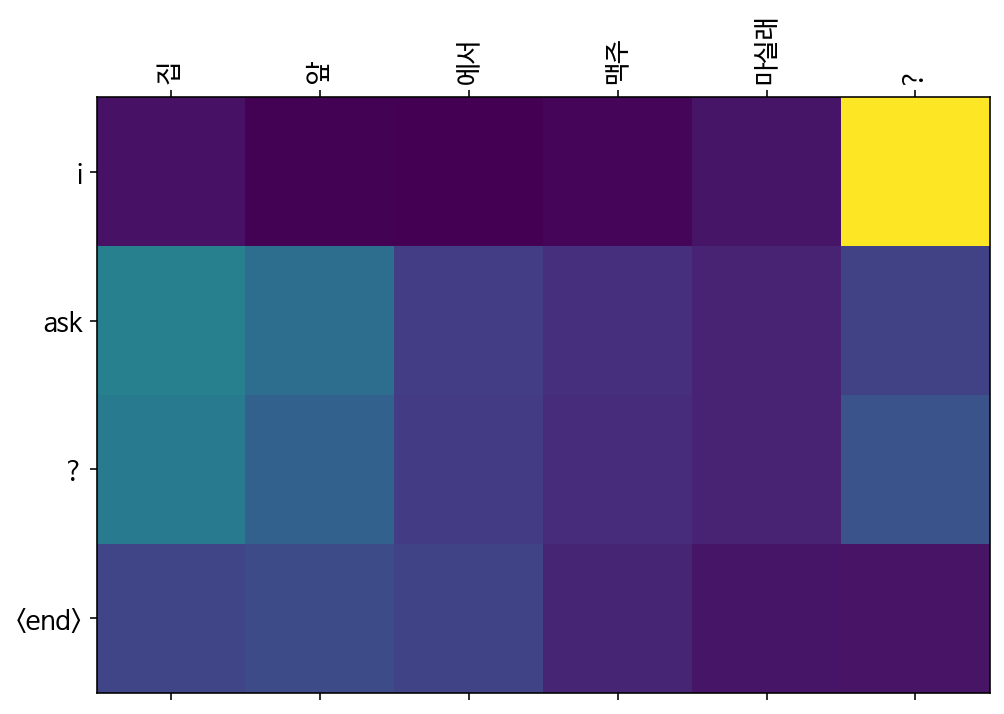

In [25]:
translate("집 앞에서 맥주 마실래?", encoder, decoder)

Input : ['사랑', '해']
Predicted translation : love for love for love for love for love for love for love for love for love for love for love for 


/tmp/ipykernel_47/3762993230.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_47/3762993230.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


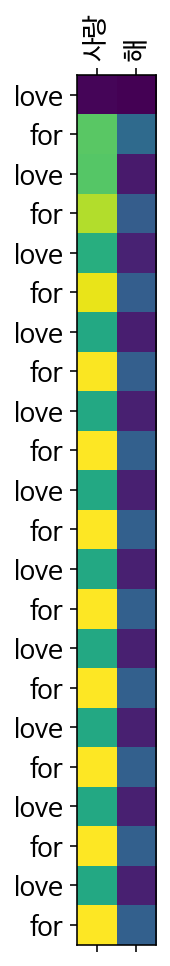

In [27]:
translate("사랑해", encoder, decoder)

Input : ['너', '지금', '뭐', '해', '?']
Predicted translation : debt to happen to the reading . <end> 


/tmp/ipykernel_47/3762993230.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_47/3762993230.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


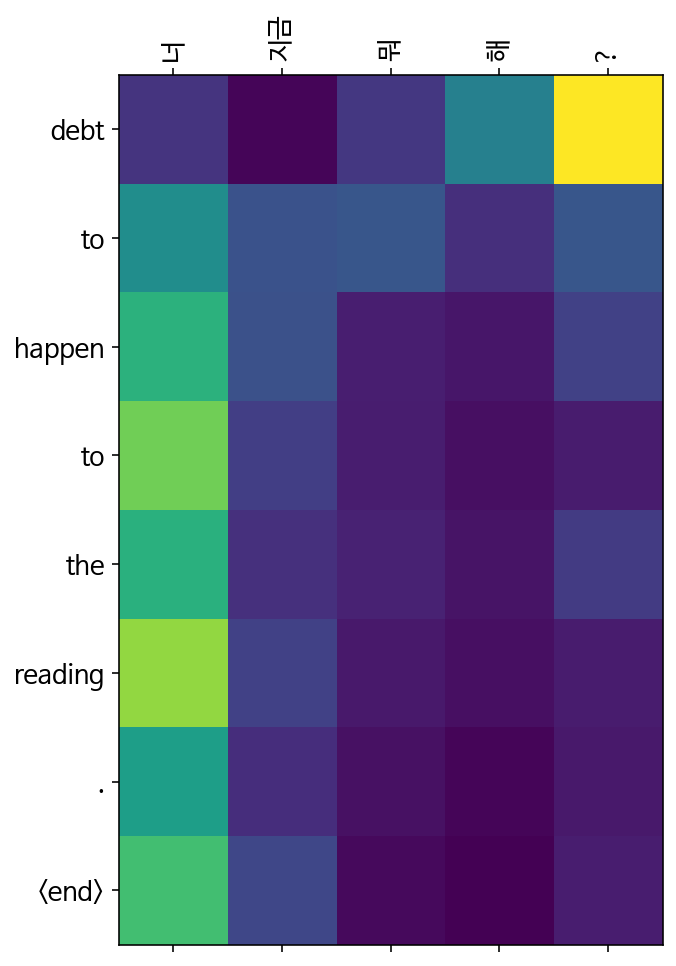

In [30]:
translate("너 지금 뭐해?", encoder, decoder)

# 회고

epoch을 10으로 하고 코드를 실행시키니 번역이 잘 되지 않는 모습을 보였다.
(the the the the the the the)  
epoch을 100으로 하니 
(i ve me?)
그래서 500으로 돌리다가 커널이 끊겨 
300까지 밖에 실행시키지 못하였는데
제대로 된 번역을 하고싶다면 어떤 모델을 쓰고 얼마나 학습시켜야하는지 궁금하다